
## Car Price Prediction

The solution is divided into the following sections:
- Data understanding and exploration
- Data cleaning
- Data preparation
- Model building and evaluation
 <font>
<div align="center"> <font size="2" color="red"><b><!--# For Citi Internal training purpose only #--></b></font> </div>

### 1. Data Understanding and Exploration

Let's first have a look at the dataset and understand the size, attribute names etc.

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn import linear_model
from sklearn.linear_model import LinearRegression as lm
import warnings
warnings.filterwarnings("ignore")

In [138]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [139]:
# reading the dataset
cars = pd.read_csv("/content/drive/MyDrive/Project/CarPrice_Assignment.csv")

In [140]:
# summary of the dataset: 205 rows, 26 columns, no null values
print(cars.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [141]:
# head
cars.head()

car_ID  symboling                   CarName fueltype aspiration doornumber  \
0       1          3        alfa-romero giulia      gas        std        two   
1       2          3       alfa-romero stelvio      gas        std        two   
2       3          1  alfa-romero Quadrifoglio      gas        std        two   
3       4          2               audi 100 ls      gas        std       four   
4       5          2                audi 100ls      gas        std       four   

       carbody drivewheel enginelocation  wheelbase  ...  enginesize  \
0  convertible        rwd          front       88.6  ...         130   
1  convertible        rwd          front       88.6  ...         130   
2    hatchback        rwd          front       94.5  ...         152   
3        sedan        fwd          front       99.8  ...         109   
4        sedan        4wd          front       99.4  ...         136   

   fuelsystem  boreratio  stroke compressionratio horsepower  peakrpm citympg  \
0        mpfi       3.47    2.68              9.0        111     5000      21   
1        mpfi       3.47    2.68              9.0        111     5000      21   
2        mpfi       2.68    3.47              9.0        154     5000      19   
3        mpfi       3.19    3.40             10.0        102     5500      24   
4        mpfi       3.19    3.40              8.0        115     5500      18   

   highwaympg    price  
0          27  13495.0  
1          27  16500.0  
2          26  16500.0  
3          30  13950.0  
4          22  17450.0  

[5 rows x 26 columns]

#### Understanding the Data Dictionary

The data dictionary contains the meaning of various attributes; some non-obvious ones are:

In [142]:
# symboling: -2 (least risky) to +3 most risky
# Most cars are 0,1,2
cars['symboling'].astype('category').value_counts()



0     67
1     54
2     32
3     27
-1    22
-2     3
Name: symboling, dtype: int64

In [143]:
# aspiration: An (internal combustion) engine property showing
# whether the oxygen intake is through standard (atmospheric pressure)
# or through turbocharging (pressurised oxygen intake)

cars['aspiration'].astype('category').value_counts()

std      168
turbo     37
Name: aspiration, dtype: int64

In [144]:
# drivewheel: frontwheel, rarewheel or four-wheel drive
cars['drivewheel'].astype('category').value_counts()

fwd    120
rwd     76
4wd      9
Name: drivewheel, dtype: int64

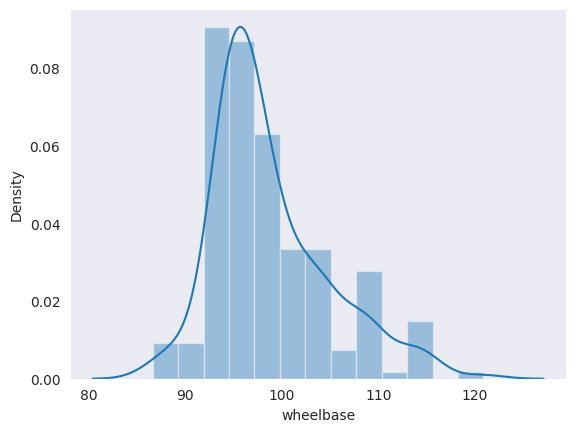

In [145]:
# wheelbase: distance between centre of front and rarewheels
sns.distplot(cars['wheelbase'])
plt.show()

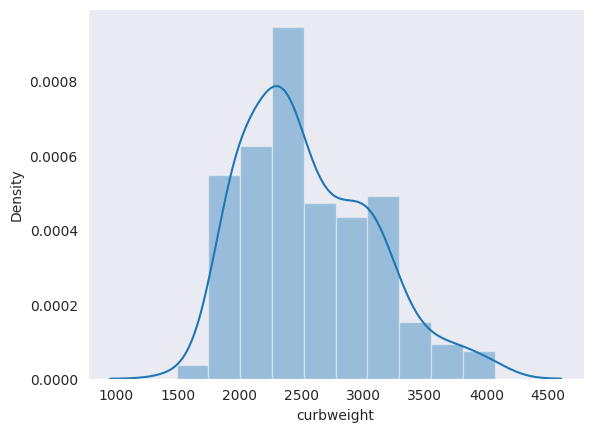

In [146]:
# curbweight: weight of car without occupants or baggage
sns.distplot(cars['curbweight'])
plt.show()

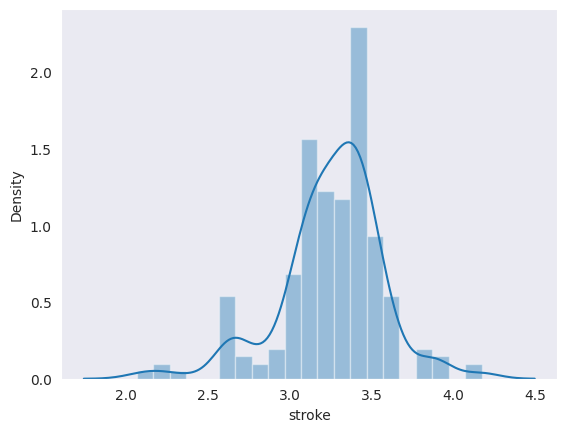

In [147]:
# stroke: volume of the engine (the distance traveled by the
# piston in each cycle)
sns.distplot(cars['stroke'])
plt.show()

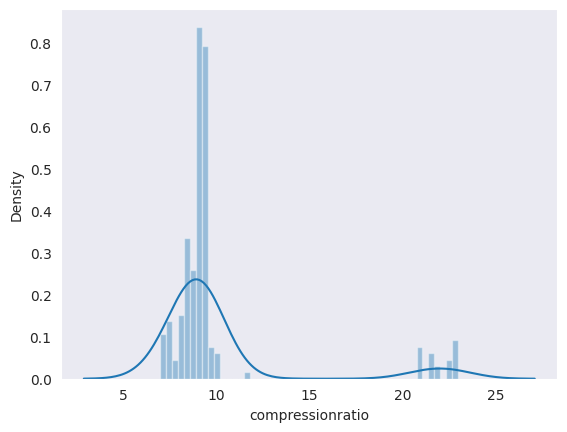

In [148]:
# compression ration: ration of volume of compression chamber
# at largest capacity to least capacity
sns.distplot(cars['compressionratio'])
plt.show()

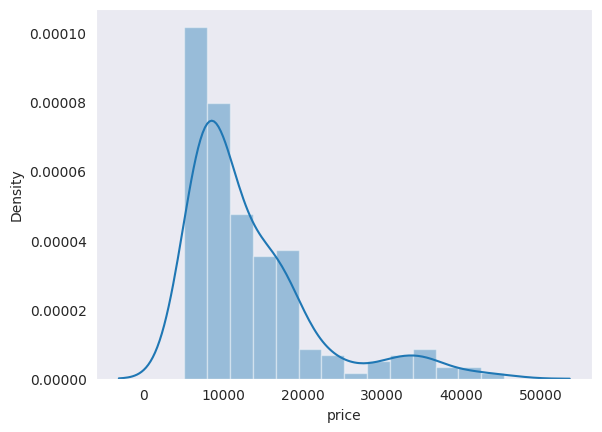

In [149]:
# target variable: price of car
sns.distplot(cars['price'])
plt.show()

#### Data Exploration

To perform linear regression, the (numeric) target variable should be linearly related to *at least one another numeric variable*. Let's see whether that's true in this case.


We'll first subset the list of all (independent) numeric variables, and then make a **pairwise plot**.

In [150]:
# all numeric (float and int) variables in the dataset
cars_numeric = cars.select_dtypes(include=['float64', 'int64'])
cars_numeric.head()

car_ID  symboling  wheelbase  carlength  carwidth  carheight  curbweight  \
0       1          3       88.6      168.8      64.1       48.8        2548   
1       2          3       88.6      168.8      64.1       48.8        2548   
2       3          1       94.5      171.2      65.5       52.4        2823   
3       4          2       99.8      176.6      66.2       54.3        2337   
4       5          2       99.4      176.6      66.4       54.3        2824   

   enginesize  boreratio  stroke  compressionratio  horsepower  peakrpm  \
0         130       3.47    2.68               9.0         111     5000   
1         130       3.47    2.68               9.0         111     5000   
2         152       2.68    3.47               9.0         154     5000   
3         109       3.19    3.40              10.0         102     5500   
4         136       3.19    3.40               8.0         115     5500   

   citympg  highwaympg    price  
0       21          27  13495.0  
1       21          27  16500.0  
2       19          26  16500.0  
3       24          30  13950.0  
4       18          22  17450.0

Here, although the variable ```symboling``` is numeric (int), we'd rather treat it as categorical since it has only 6 discrete values. Also, we do not want 'car_ID'.

In [151]:
# dropping symboling and car_ID
cars_numeric = cars_numeric.drop(['car_ID'], axis=1)
cars_numeric.head()

symboling  wheelbase  carlength  carwidth  carheight  curbweight  \
0          3       88.6      168.8      64.1       48.8        2548   
1          3       88.6      168.8      64.1       48.8        2548   
2          1       94.5      171.2      65.5       52.4        2823   
3          2       99.8      176.6      66.2       54.3        2337   
4          2       99.4      176.6      66.4       54.3        2824   

   enginesize  boreratio  stroke  compressionratio  horsepower  peakrpm  \
0         130       3.47    2.68               9.0         111     5000   
1         130       3.47    2.68               9.0         111     5000   
2         152       2.68    3.47               9.0         154     5000   
3         109       3.19    3.40              10.0         102     5500   
4         136       3.19    3.40               8.0         115     5500   

   citympg  highwaympg    price  
0       21          27  13495.0  
1       21          27  16500.0  
2       19          26  16500.0  
3       24          30  13950.0  
4       18          22  17450.0

Let's now make a pairwise scatter plot and observe linear relationships.

<Figure size 2000x1000 with 0 Axes>

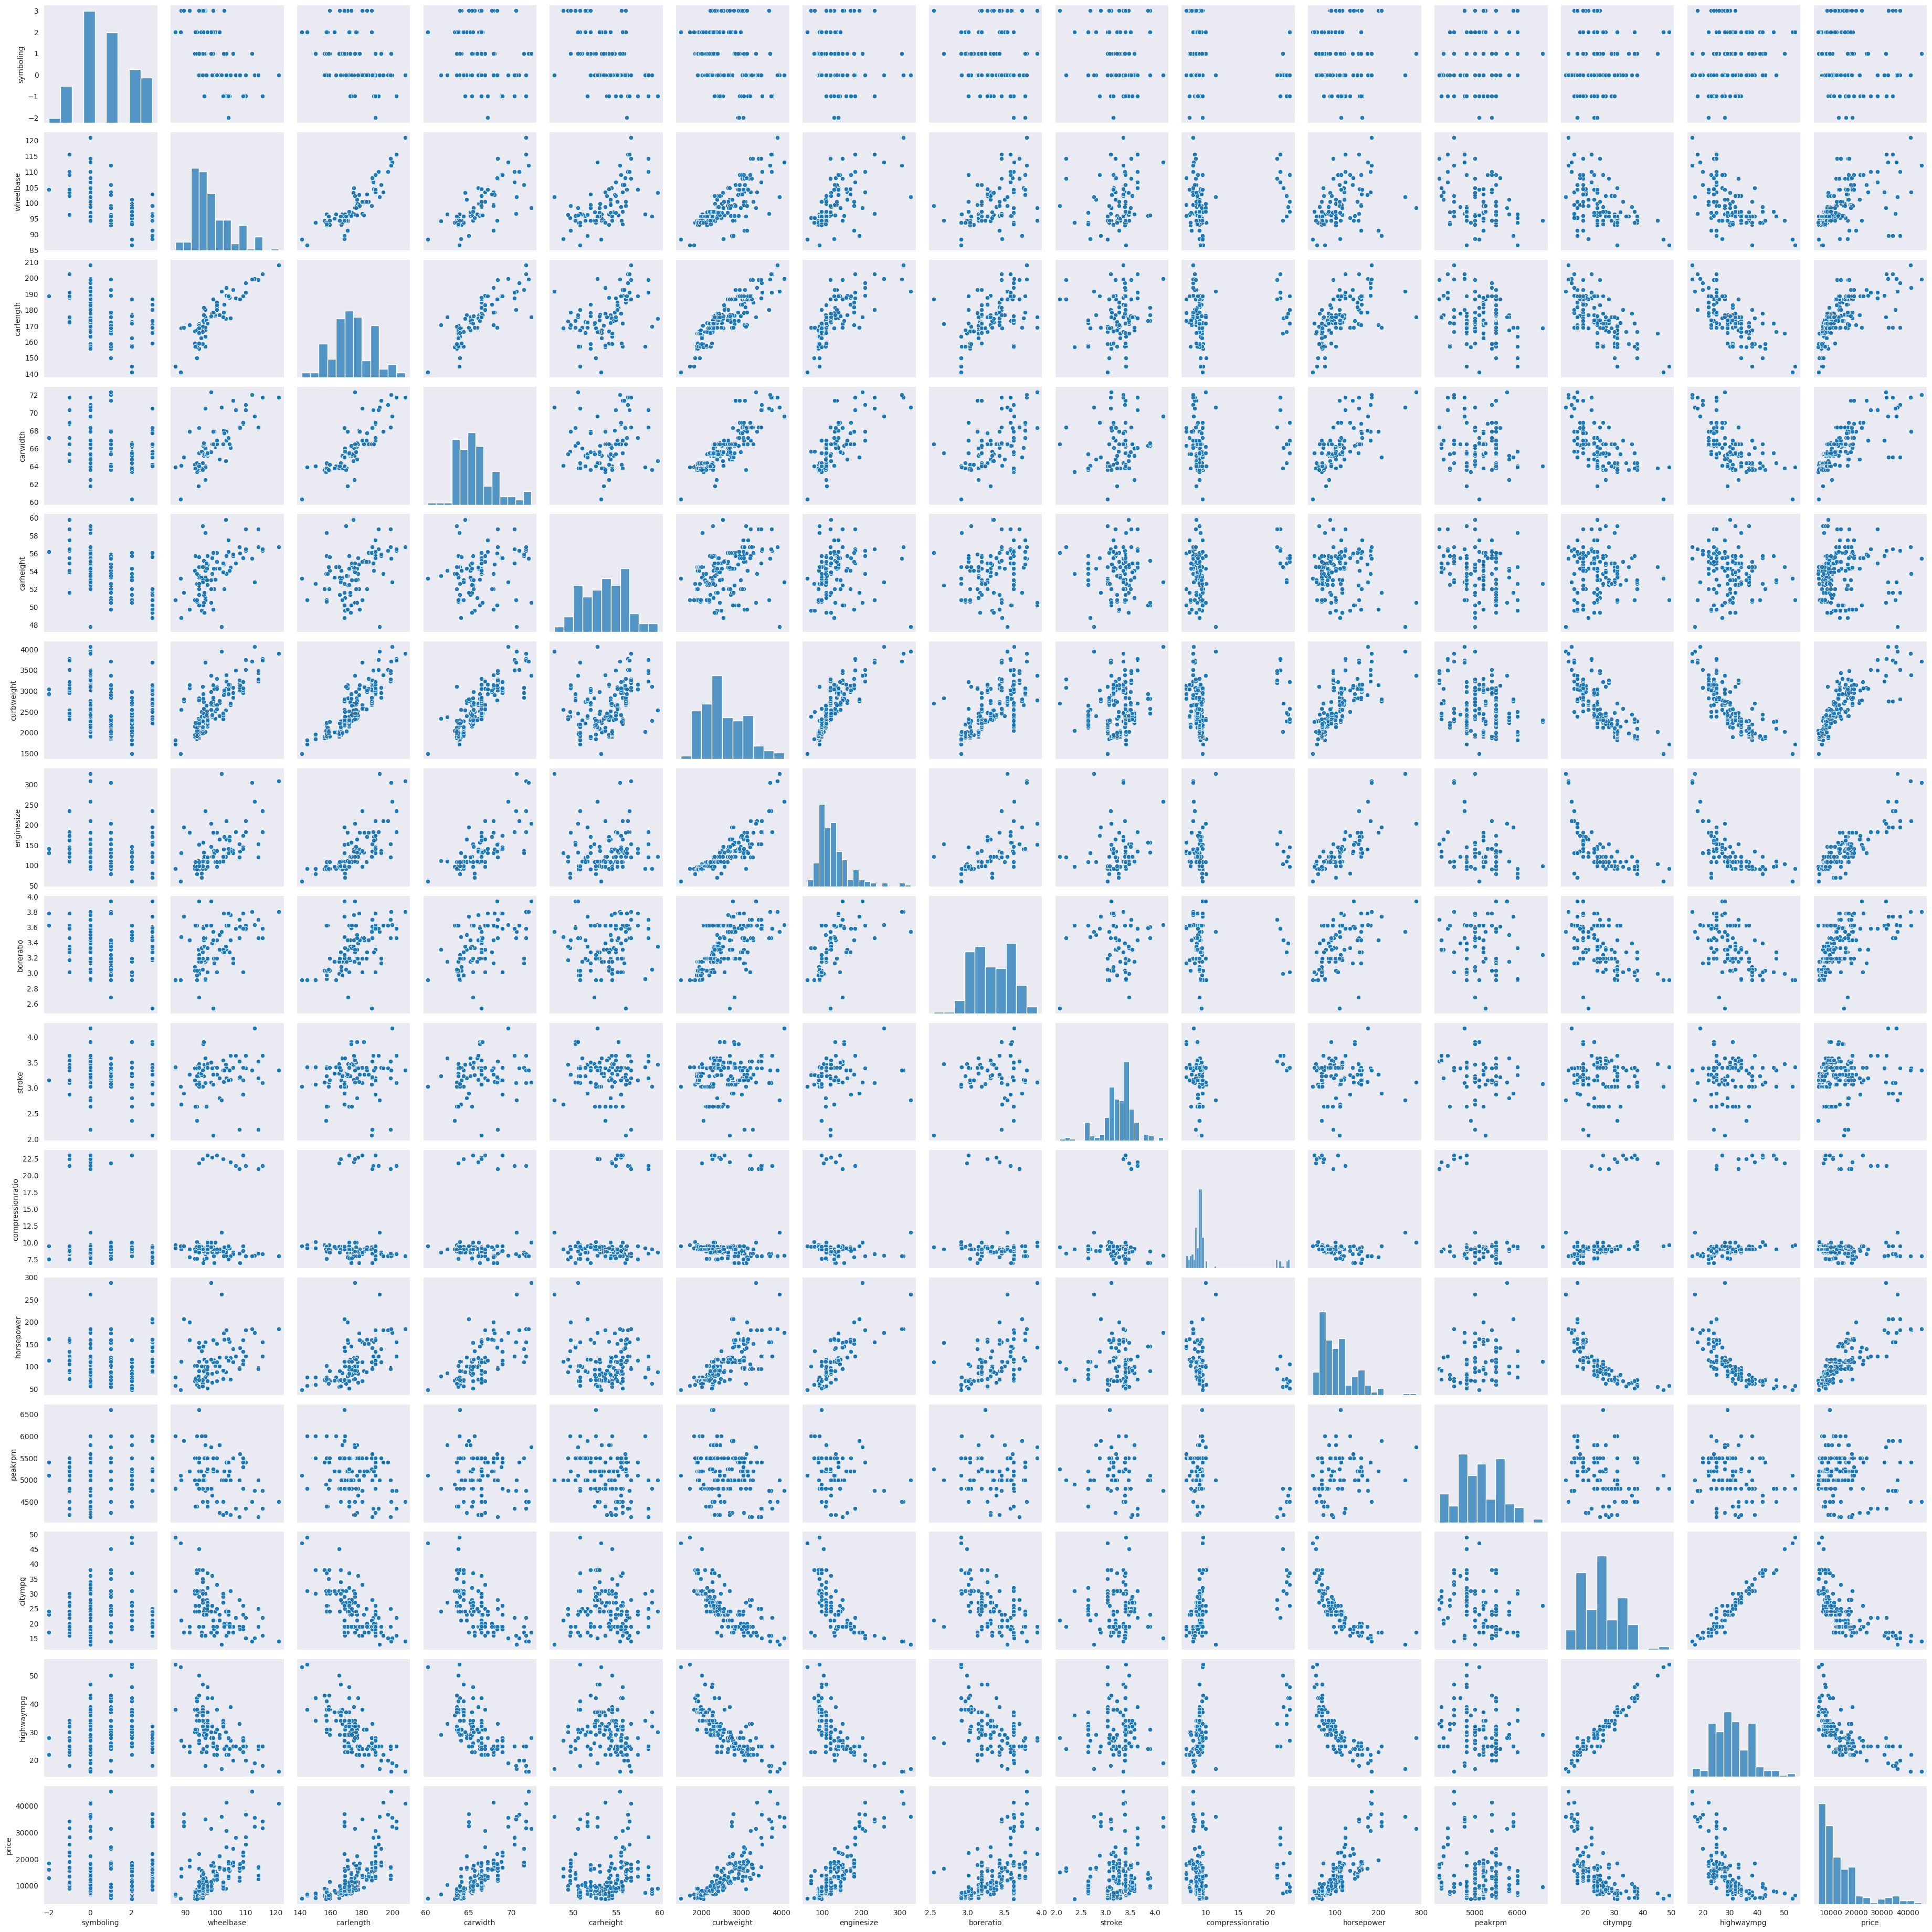

In [152]:
# paiwise scatter plot

plt.figure(figsize=(20, 10))
sns.pairplot(cars_numeric)
plt.show()

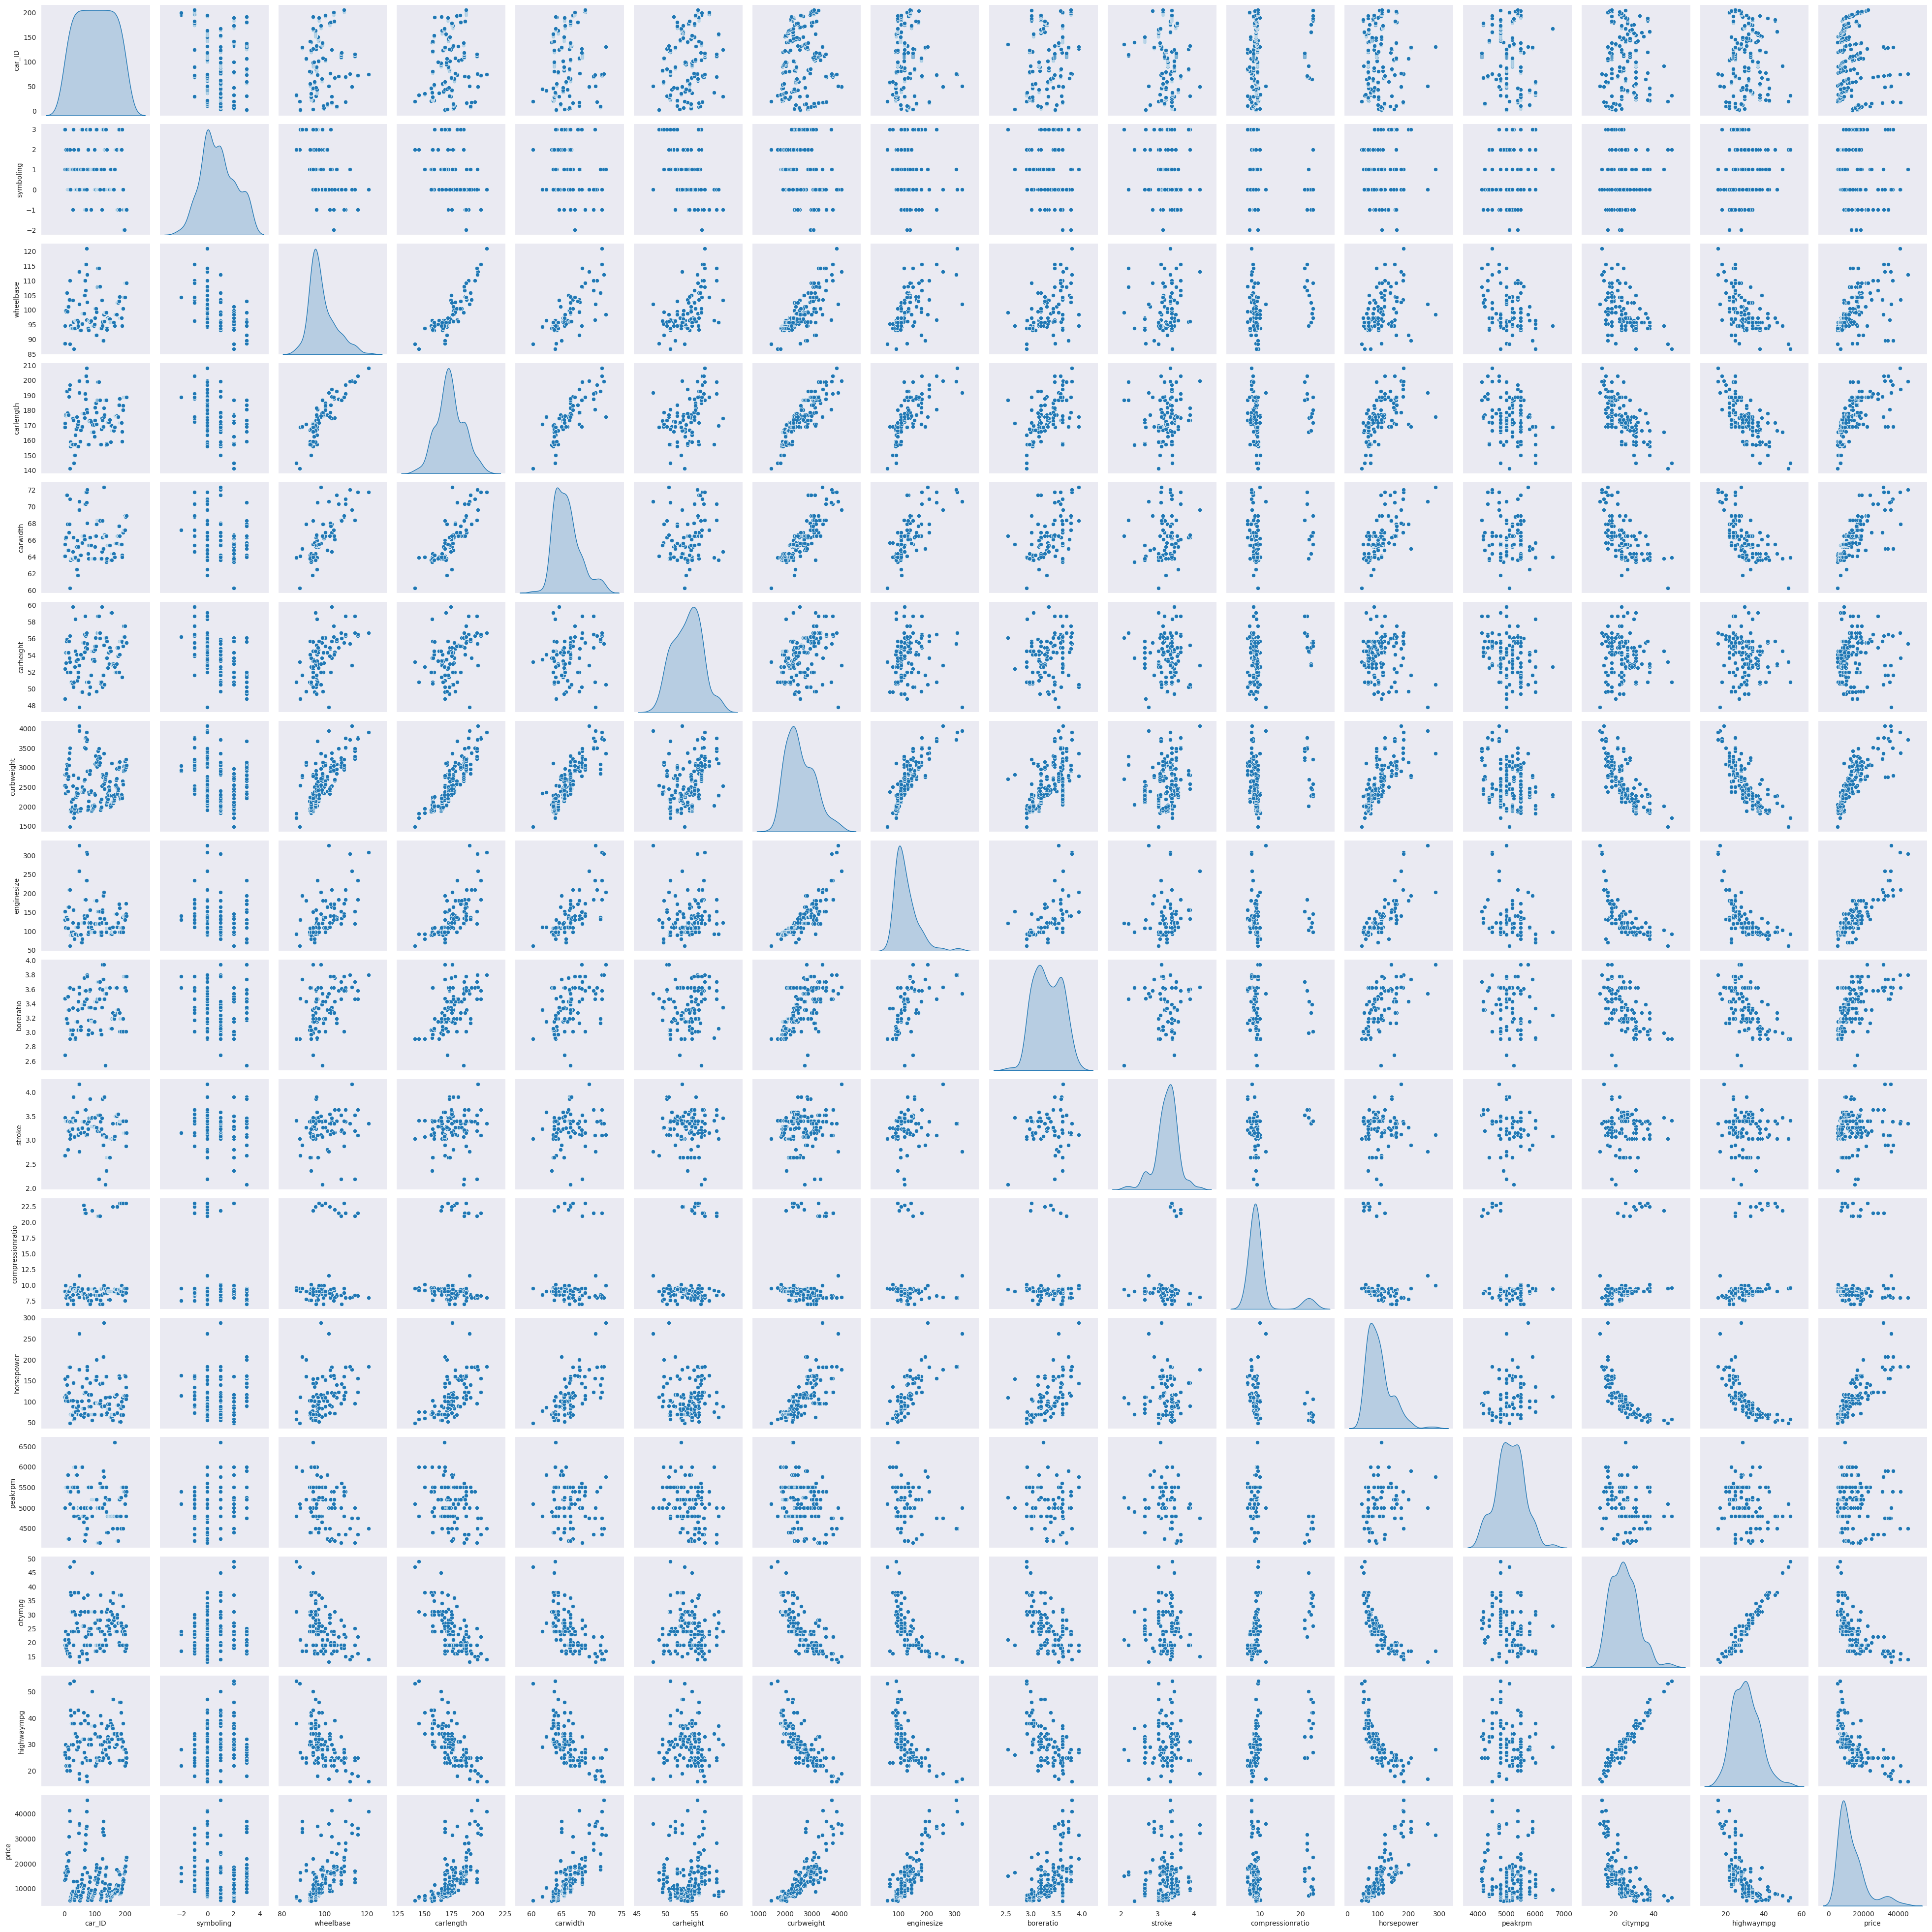

In [93]:
sns.pairplot(cars,diag_kind='kde')

This is quite hard to read, and we can rather plot correlations between variables. Also, a heatmap is pretty useful to visualise multiple correlations in one plot.

In [94]:
# correlation matrix
cor = cars_numeric.corr()
cor

symboling  wheelbase  carlength  carwidth  carheight  \
symboling          1.000000  -0.531954  -0.357612 -0.232919  -0.541038   
wheelbase         -0.531954   1.000000   0.874587  0.795144   0.589435   
carlength         -0.357612   0.874587   1.000000  0.841118   0.491029   
carwidth          -0.232919   0.795144   0.841118  1.000000   0.279210   
carheight         -0.541038   0.589435   0.491029  0.279210   1.000000   
curbweight        -0.227691   0.776386   0.877728  0.867032   0.295572   
enginesize        -0.105790   0.569329   0.683360  0.735433   0.067149   
boreratio         -0.130051   0.488750   0.606454  0.559150   0.171071   
stroke            -0.008735   0.160959   0.129533  0.182942  -0.055307   
compressionratio  -0.178515   0.249786   0.158414  0.181129   0.261214   
horsepower         0.070873   0.353294   0.552623  0.640732  -0.108802   
peakrpm            0.273606  -0.360469  -0.287242 -0.220012  -0.320411   
citympg           -0.035823  -0.470414  -0.670909 -0.642704  -0.048640   
highwaympg         0.034606  -0.544082  -0.704662 -0.677218  -0.107358   
price             -0.079978   0.577816   0.682920  0.759325   0.119336   

                  curbweight  enginesize  boreratio    stroke  \
symboling          -0.227691   -0.105790  -0.130051 -0.008735   
wheelbase           0.776386    0.569329   0.488750  0.160959   
carlength           0.877728    0.683360   0.606454  0.129533   
carwidth            0.867032    0.735433   0.559150  0.182942   
carheight           0.295572    0.067149   0.171071 -0.055307   
curbweight          1.000000    0.850594   0.648480  0.168790   
enginesize          0.850594    1.000000   0.583774  0.203129   
boreratio           0.648480    0.583774   1.000000 -0.055909   
stroke              0.168790    0.203129  -0.055909  1.000000   
compressionratio    0.151362    0.028971   0.005197  0.186110   
horsepower          0.750739    0.809769   0.573677  0.080940   
peakrpm            -0.266243   -0.244660  -0.254976 -0.067964   
citympg            -0.757414   -0.653658  -0.584532 -0.042145   
highwaympg         -0.797465   -0.677470  -0.587012 -0.043931   
price               0.835305    0.874145   0.553173  0.079443   

                  compressionratio  horsepower   peakrpm   citympg  \
symboling                -0.178515    0.070873  0.273606 -0.035823   
wheelbase                 0.249786    0.353294 -0.360469 -0.470414   
carlength                 0.158414    0.552623 -0.287242 -0.670909   
carwidth                  0.181129    0.640732 -0.220012 -0.642704   
carheight                 0.261214   -0.108802 -0.320411 -0.048640   
curbweight                0.151362    0.750739 -0.266243 -0.757414   
enginesize                0.028971    0.809769 -0.244660 -0.653658   
boreratio                 0.005197    0.573677 -0.254976 -0.584532   
stroke                    0.186110    0.080940 -0.067964 -0.042145   
compressionratio          1.000000   -0.204326 -0.435741  0.324701   
horsepower               -0.204326    1.000000  0.131073 -0.801456   
peakrpm                  -0.435741    0.131073  1.000000 -0.113544   
citympg                   0.324701   -0.801456 -0.113544  1.000000   
highwaympg                0.265201   -0.770544 -0.054275  0.971337   
price                     0.067984    0.808139 -0.085267 -0.685751   

                  highwaympg     price  
symboling           0.034606 -0.079978  
wheelbase          -0.544082  0.577816  
carlength          -0.704662  0.682920  
carwidth           -0.677218  0.759325  
carheight          -0.107358  0.119336  
curbweight         -0.797465  0.835305  
enginesize         -0.677470  0.874145  
boreratio          -0.587012  0.553173  
stroke             -0.043931  0.079443  
compressionratio    0.265201  0.067984  
horsepower         -0.770544  0.808139  
peakrpm            -0.054275 -0.085267  
citympg             0.971337 -0.685751  
highwaympg          1.000000 -0.697599  
price              -0.697599  1.000000

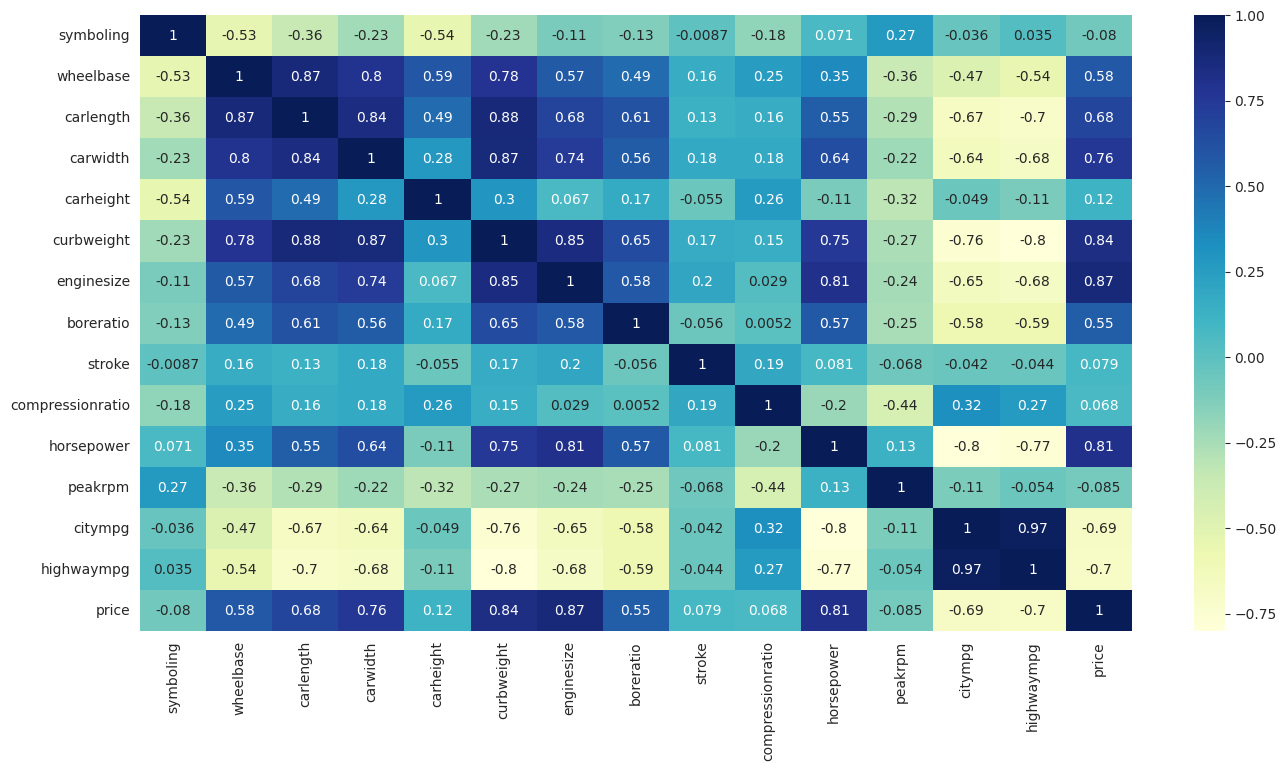

In [95]:
# plotting correlations on a heatmap

# figure size
plt.figure(figsize=(16,8))

# heatmap
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()


The heatmap shows some useful insights:

Correlation of price with independent variables:
- Price is highly (positively) correlated with wheelbase, carlength, carwidth, curbweight, enginesize, horsepower (notice how all of these variables represent the size/weight/engine power of the car)

- Price is negatively correlated to ```citympg``` and ```highwaympg``` (-0.70 approximately). This suggest that cars having high mileage may fall in the 'economy' cars category, and are priced lower (think Maruti Alto/Swift type of cars, which are designed to be affordable by the middle class, who value mileage more than horsepower/size of car etc.)

Correlation among independent variables:
- Many independent variables are highly correlated (look at the top-left part of matrix): wheelbase, carlength, curbweight, enginesize etc. are all measures of 'size/weight', and are positively correlated


Thus, while building the model, we'll have to pay attention to multicollinearity (especially linear models, such as linear and logistic regression, suffer more from multicollinearity).

## 2. Data Cleaning

Let's now conduct some data cleaning steps.

We've seen that there are no missing values in the dataset. We've also seen that variables are in the correct format, except ```symboling```, which should rather be a categorical variable (so that dummy variable are created for the categories).

Note that it *can* be used in the model as a numeric variable also.



In [96]:
# variable formats
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [97]:
# converting symboling to categorical
cars['symboling'] = cars['symboling'].astype('object')
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    object 
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

Netx, we need to extract the company name from the column ```CarName```.

In [98]:
# CarName: first few entries
cars['CarName']

0            alfa-romero giulia
1           alfa-romero stelvio
2      alfa-romero Quadrifoglio
3                   audi 100 ls
4                    audi 100ls
                 ...           
200             volvo 145e (sw)
201                 volvo 144ea
202                 volvo 244dl
203                   volvo 246
204                 volvo 264gl
Name: CarName, Length: 205, dtype: object

Notice that the carname is what occurs before a space, e.g. alfa-romero, audi, chevrolet, dodge, bmx etc.

Thus, we need to simply extract the string before a space. There are multiple ways to do that.




In [99]:
# Extracting carname

# Method 1: str.split() by space
carnames = cars['CarName'].apply(lambda x: x.split(" ")[0])
carnames[:30]

0     alfa-romero
1     alfa-romero
2     alfa-romero
3            audi
4            audi
5            audi
6            audi
7            audi
8            audi
9            audi
10            bmw
11            bmw
12            bmw
13            bmw
14            bmw
15            bmw
16            bmw
17            bmw
18      chevrolet
19      chevrolet
20      chevrolet
21          dodge
22          dodge
23          dodge
24          dodge
25          dodge
26          dodge
27          dodge
28          dodge
29          dodge
Name: CarName, dtype: object

In [100]:
# Method 2: Use regular expressions
import re

# regex: any alphanumeric sequence before a space, may contain a hyphen
p = re.compile(r'\w+-?\w+')
carnames = cars['CarName'].apply(lambda x: re.findall(p, x)[0])
print(carnames)

0      alfa-romero
1      alfa-romero
2      alfa-romero
3             audi
4             audi
          ...     
200          volvo
201          volvo
202          volvo
203          volvo
204          volvo
Name: CarName, Length: 205, dtype: object


Let's create a new column to store the compnay name and check whether it looks okay.

In [101]:
# New column car_company
cars['car_company'] = cars['CarName'].apply(lambda x: re.findall(p, x)[0])

In [102]:
# look at all values
cars['car_company'].value_counts()

toyota         31
nissan         17
mazda          15
honda          13
mitsubishi     13
subaru         12
peugeot        11
volvo          11
volkswagen      9
dodge           9
buick           8
bmw             8
audi            7
plymouth        7
saab            6
isuzu           4
porsche         4
alfa-romero     3
chevrolet       3
jaguar          3
vw              2
maxda           2
renault         2
toyouta         1
vokswagen       1
Nissan          1
mercury         1
porcshce        1
Name: car_company, dtype: int64

Notice that **some car-company names are misspelled** - vw and vokswagen should be volkswagen, porcshce should be porsche, toyouta should be toyota, Nissan should be nissan, maxda should be mazda etc.

This is a data quality issue, let's solve it.

In [103]:
# replacing misspelled car_company names

# volkswagen
cars.loc[(cars['car_company'] == "vw") |
         (cars['car_company'] == "vokswagen")
         , 'car_company'] = 'volkswagen'

# porsche
cars.loc[cars['car_company'] == "porcshce", 'car_company'] = 'porsche'

# toyota
cars.loc[cars['car_company'] == "toyouta", 'car_company'] = 'toyota'

# nissan
cars.loc[cars['car_company'] == "Nissan", 'car_company'] = 'nissan'

# mazda
cars.loc[cars['car_company'] == "maxda", 'car_company'] = 'mazda'

In [104]:
cars['car_company'].astype('category').value_counts()

toyota         32
nissan         18
mazda          17
mitsubishi     13
honda          13
volkswagen     12
subaru         12
peugeot        11
volvo          11
dodge           9
buick           8
bmw             8
audi            7
plymouth        7
saab            6
porsche         5
isuzu           4
jaguar          3
chevrolet       3
alfa-romero     3
renault         2
mercury         1
Name: car_company, dtype: int64

The ```car_company``` variable looks okay now. Let's now drop the car name variable.

In [105]:
# drop carname variable
cars = cars.drop('CarName', axis=1)

In [106]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    object 
 2   fueltype          205 non-null    object 
 3   aspiration        205 non-null    object 
 4   doornumber        205 non-null    object 
 5   carbody           205 non-null    object 
 6   drivewheel        205 non-null    object 
 7   enginelocation    205 non-null    object 
 8   wheelbase         205 non-null    float64
 9   carlength         205 non-null    float64
 10  carwidth          205 non-null    float64
 11  carheight         205 non-null    float64
 12  curbweight        205 non-null    int64  
 13  enginetype        205 non-null    object 
 14  cylindernumber    205 non-null    object 
 15  enginesize        205 non-null    int64  
 16  fuelsystem        205 non-null    object 
 1

In [107]:
# outliers
cars.describe()

car_ID   wheelbase   carlength    carwidth   carheight  \
count  205.000000  205.000000  205.000000  205.000000  205.000000   
mean   103.000000   98.756585  174.049268   65.907805   53.724878   
std     59.322565    6.021776   12.337289    2.145204    2.443522   
min      1.000000   86.600000  141.100000   60.300000   47.800000   
25%     52.000000   94.500000  166.300000   64.100000   52.000000   
50%    103.000000   97.000000  173.200000   65.500000   54.100000   
75%    154.000000  102.400000  183.100000   66.900000   55.500000   
max    205.000000  120.900000  208.100000   72.300000   59.800000   

        curbweight  enginesize   boreratio      stroke  compressionratio  \
count   205.000000  205.000000  205.000000  205.000000        205.000000   
mean   2555.565854  126.907317    3.329756    3.255415         10.142537   
std     520.680204   41.642693    0.270844    0.313597          3.972040   
min    1488.000000   61.000000    2.540000    2.070000          7.000000   
25%    2145.000000   97.000000    3.150000    3.110000          8.600000   
50%    2414.000000  120.000000    3.310000    3.290000          9.000000   
75%    2935.000000  141.000000    3.580000    3.410000          9.400000   
max    4066.000000  326.000000    3.940000    4.170000         23.000000   

       horsepower      peakrpm     citympg  highwaympg         price  
count  205.000000   205.000000  205.000000  205.000000    205.000000  
mean   104.117073  5125.121951   25.219512   30.751220  13276.710571  
std     39.544167   476.985643    6.542142    6.886443   7988.852332  
min     48.000000  4150.000000   13.000000   16.000000   5118.000000  
25%     70.000000  4800.000000   19.000000   25.000000   7788.000000  
50%     95.000000  5200.000000   24.000000   30.000000  10295.000000  
75%    116.000000  5500.000000   30.000000   34.000000  16503.000000  
max    288.000000  6600.000000   49.000000   54.000000  45400.000000

In [108]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    object 
 2   fueltype          205 non-null    object 
 3   aspiration        205 non-null    object 
 4   doornumber        205 non-null    object 
 5   carbody           205 non-null    object 
 6   drivewheel        205 non-null    object 
 7   enginelocation    205 non-null    object 
 8   wheelbase         205 non-null    float64
 9   carlength         205 non-null    float64
 10  carwidth          205 non-null    float64
 11  carheight         205 non-null    float64
 12  curbweight        205 non-null    int64  
 13  enginetype        205 non-null    object 
 14  cylindernumber    205 non-null    object 
 15  enginesize        205 non-null    int64  
 16  fuelsystem        205 non-null    object 
 1

### Missing value and Outlier detection

In [109]:
cars.isnull().any()

car_ID              False
symboling           False
fueltype            False
aspiration          False
doornumber          False
carbody             False
drivewheel          False
enginelocation      False
wheelbase           False
carlength           False
carwidth            False
carheight           False
curbweight          False
enginetype          False
cylindernumber      False
enginesize          False
fuelsystem          False
boreratio           False
stroke              False
compressionratio    False
horsepower          False
peakrpm             False
citympg             False
highwaympg          False
price               False
car_company         False
dtype: bool

### No missing values in  any columns

In [110]:
# car_df_final_imp=cars.fillna(cars.median())

<ipython-input-111-32897acfbb08>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], label="skew: " + str(np.round(df[col].skew(),2)))


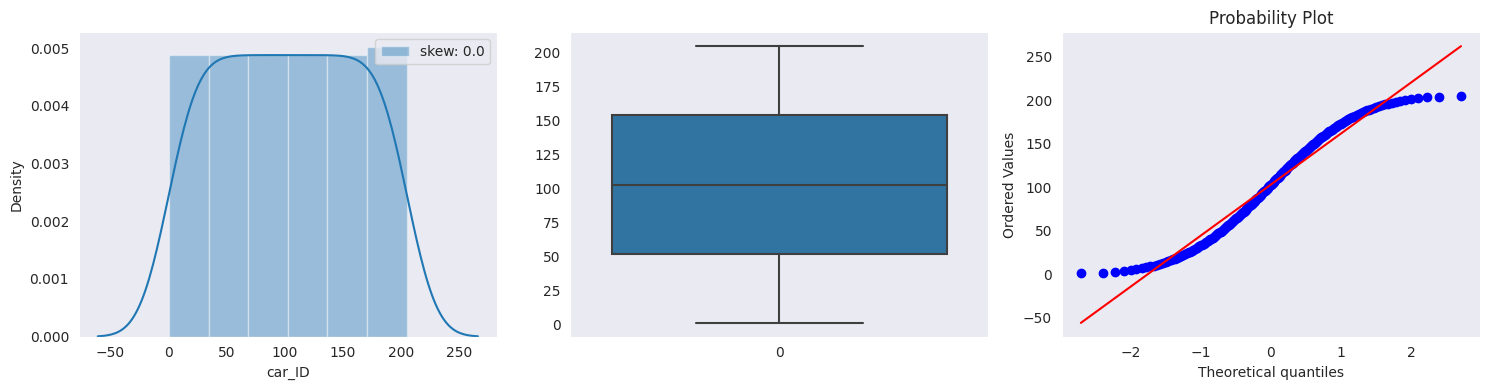

<ipython-input-111-32897acfbb08>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], label="skew: " + str(np.round(df[col].skew(),2)))


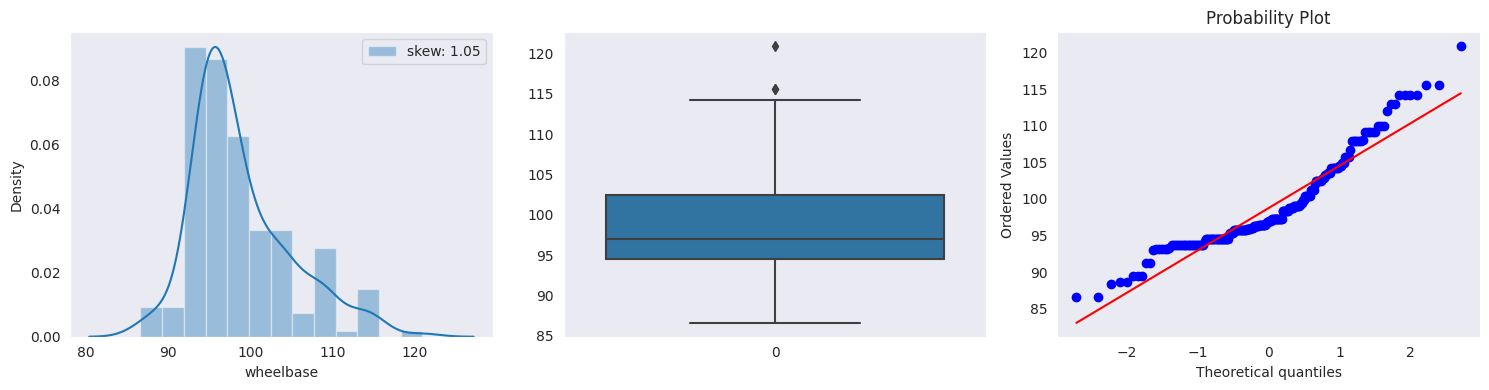

<ipython-input-111-32897acfbb08>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], label="skew: " + str(np.round(df[col].skew(),2)))


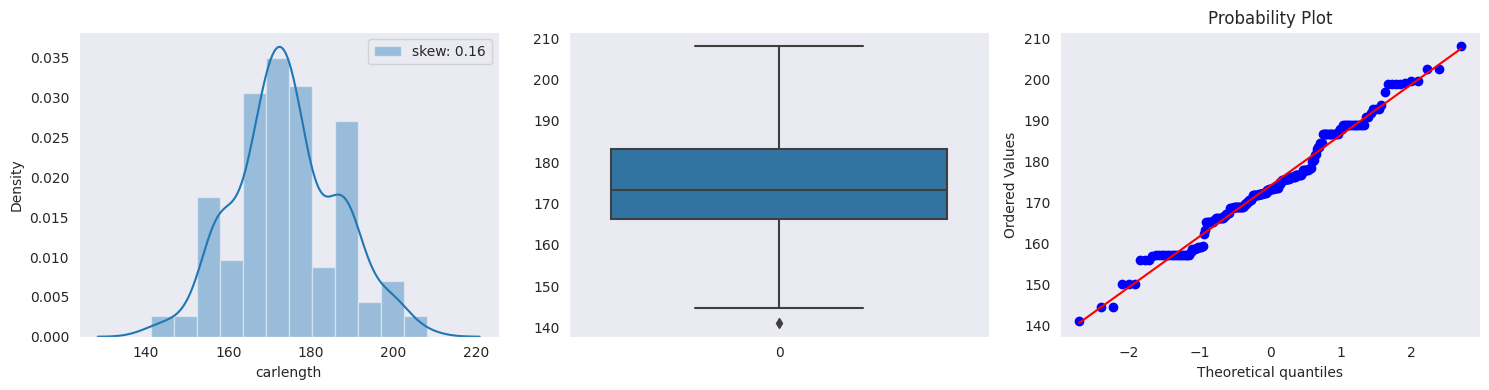

<ipython-input-111-32897acfbb08>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], label="skew: " + str(np.round(df[col].skew(),2)))


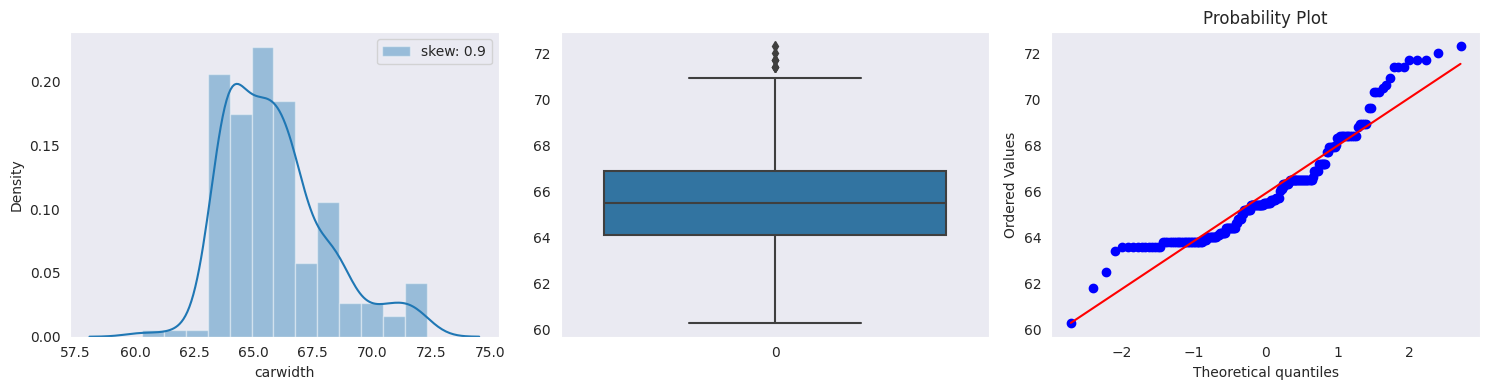

<ipython-input-111-32897acfbb08>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], label="skew: " + str(np.round(df[col].skew(),2)))


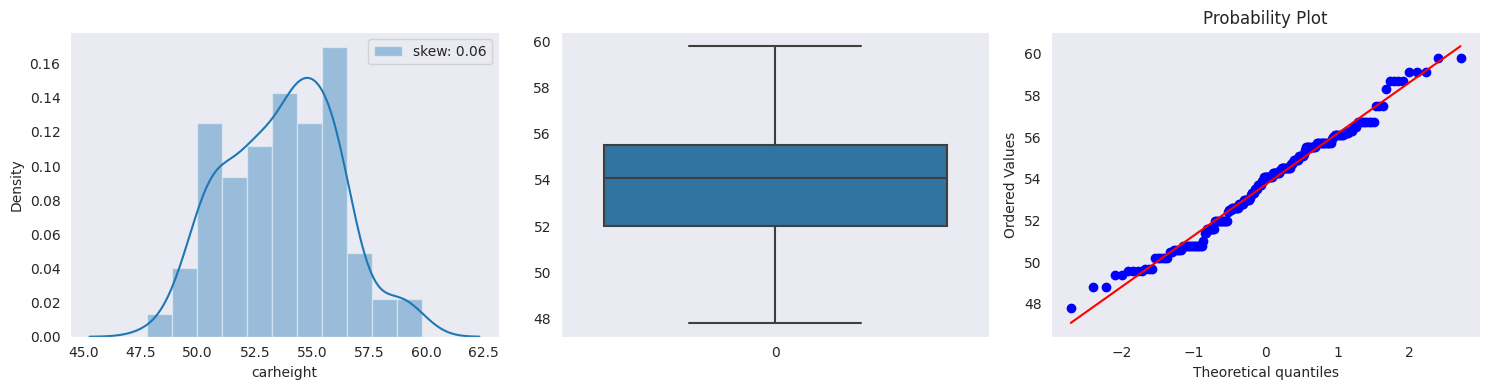

<ipython-input-111-32897acfbb08>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], label="skew: " + str(np.round(df[col].skew(),2)))


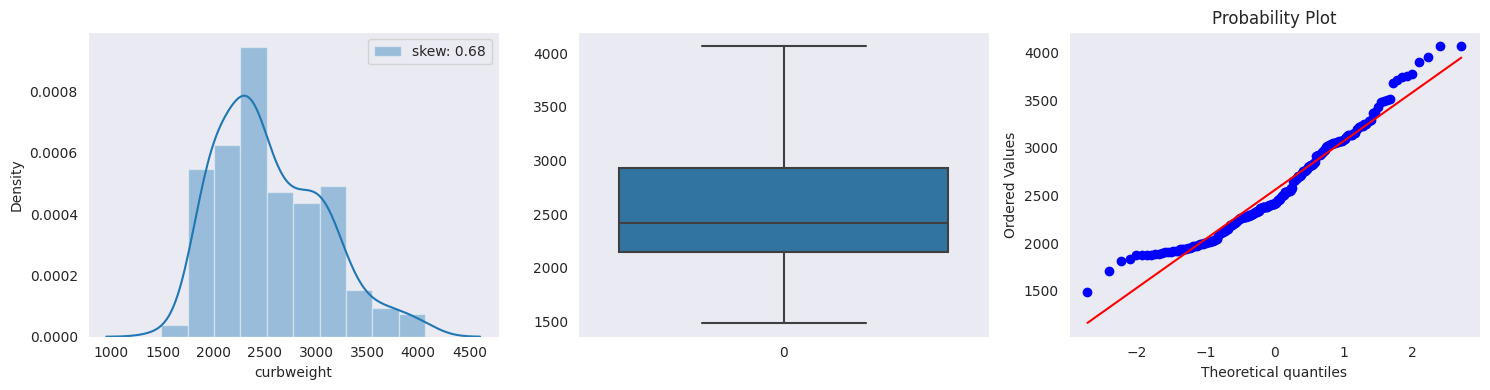

<ipython-input-111-32897acfbb08>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], label="skew: " + str(np.round(df[col].skew(),2)))


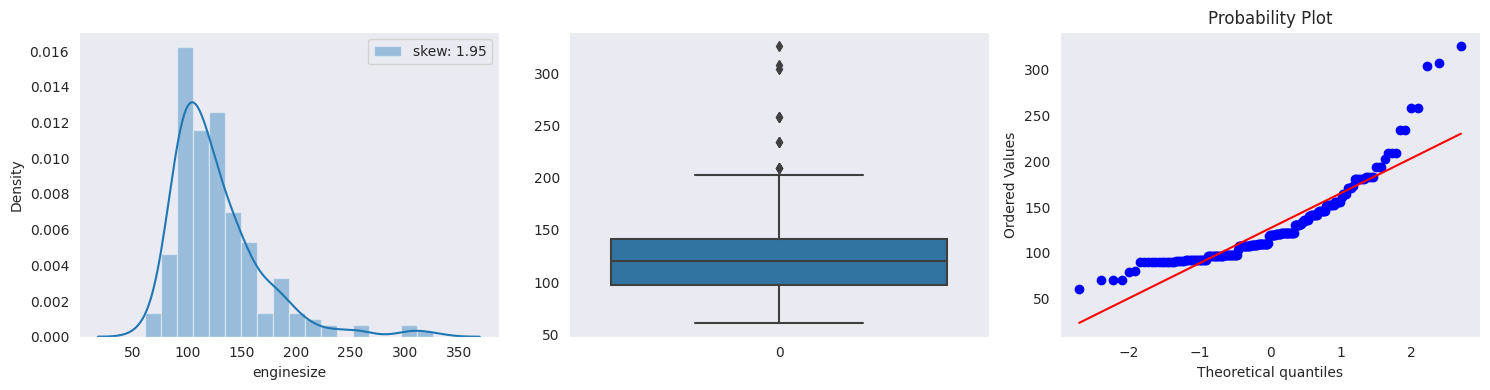

<ipython-input-111-32897acfbb08>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], label="skew: " + str(np.round(df[col].skew(),2)))


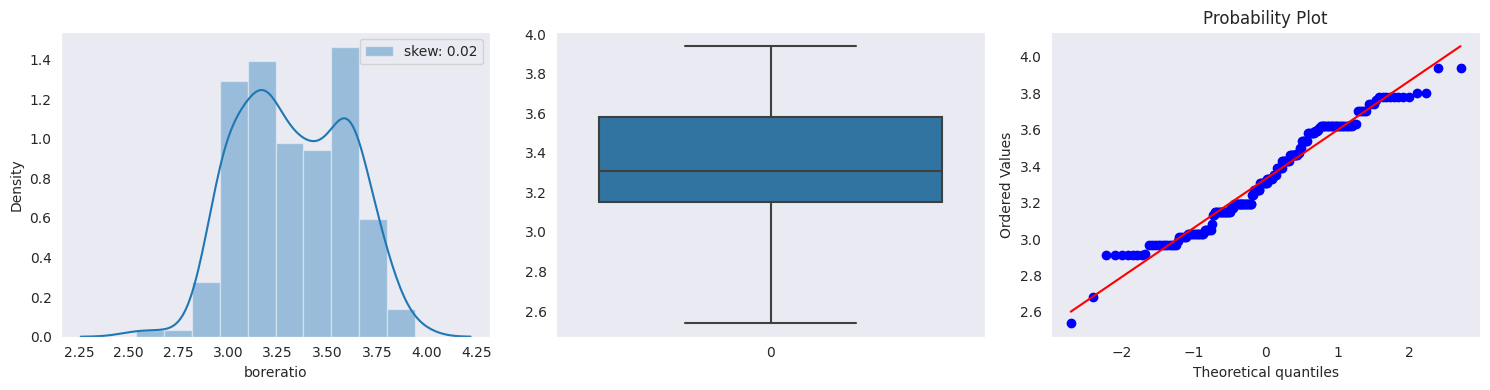

<ipython-input-111-32897acfbb08>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], label="skew: " + str(np.round(df[col].skew(),2)))


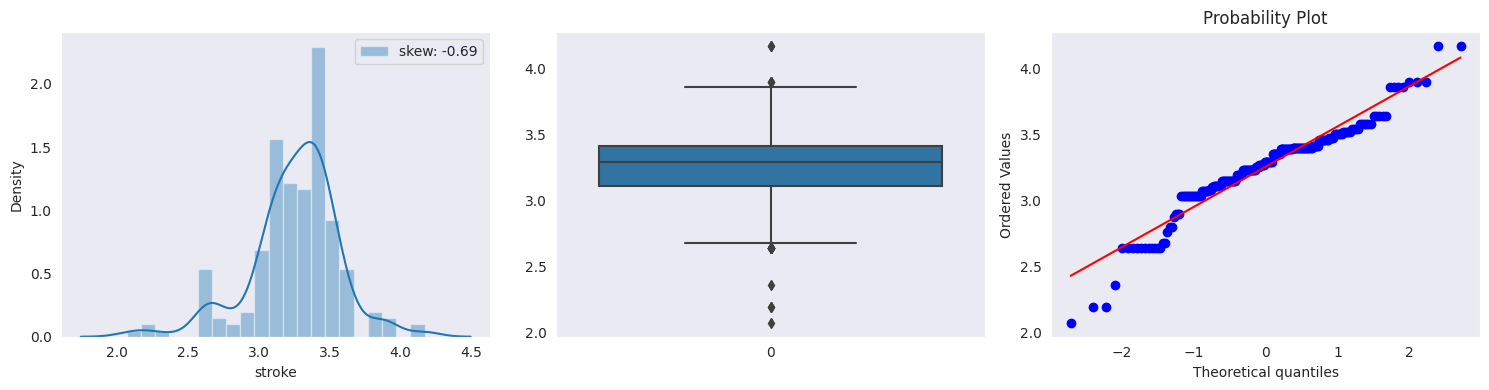

<ipython-input-111-32897acfbb08>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], label="skew: " + str(np.round(df[col].skew(),2)))


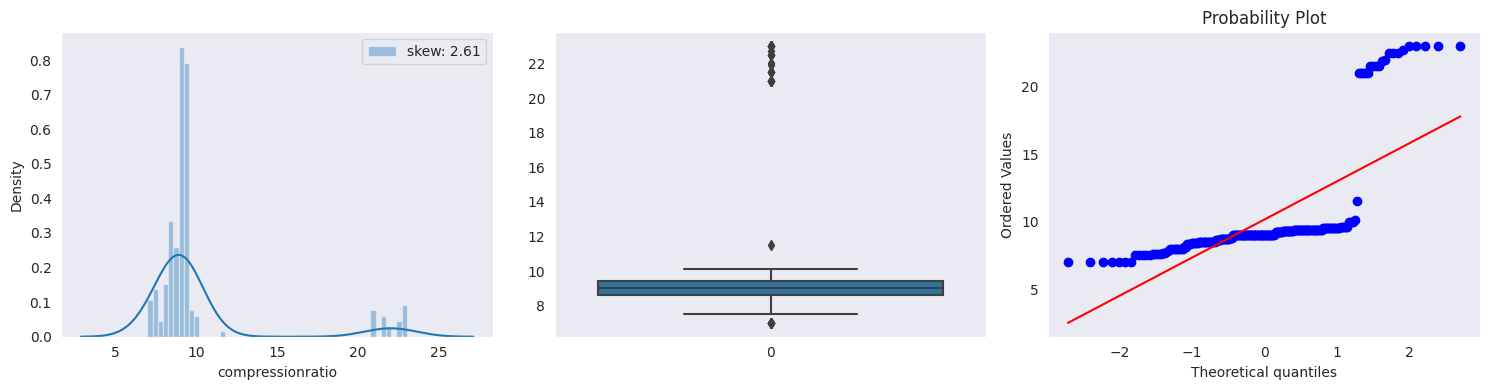

<ipython-input-111-32897acfbb08>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], label="skew: " + str(np.round(df[col].skew(),2)))


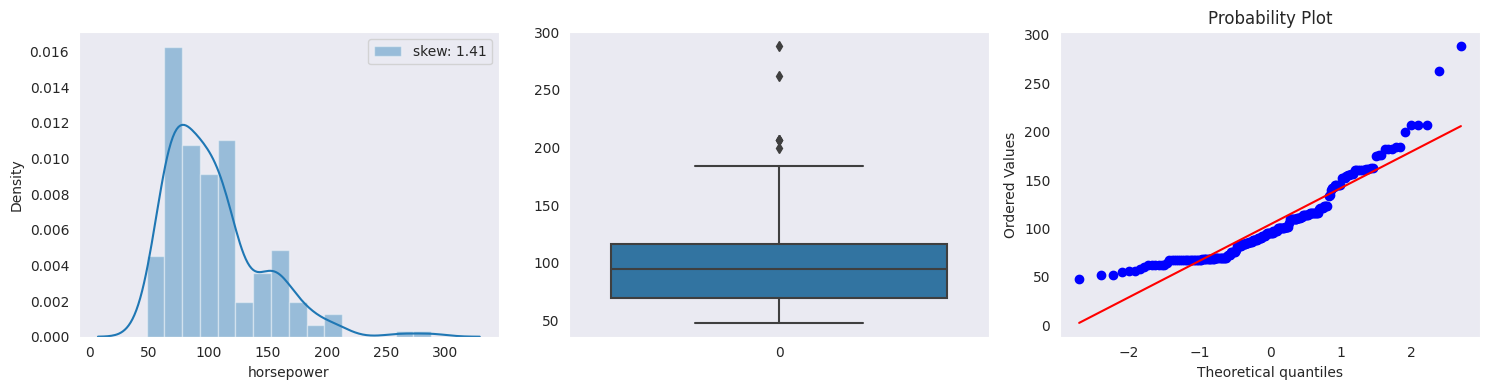

<ipython-input-111-32897acfbb08>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], label="skew: " + str(np.round(df[col].skew(),2)))


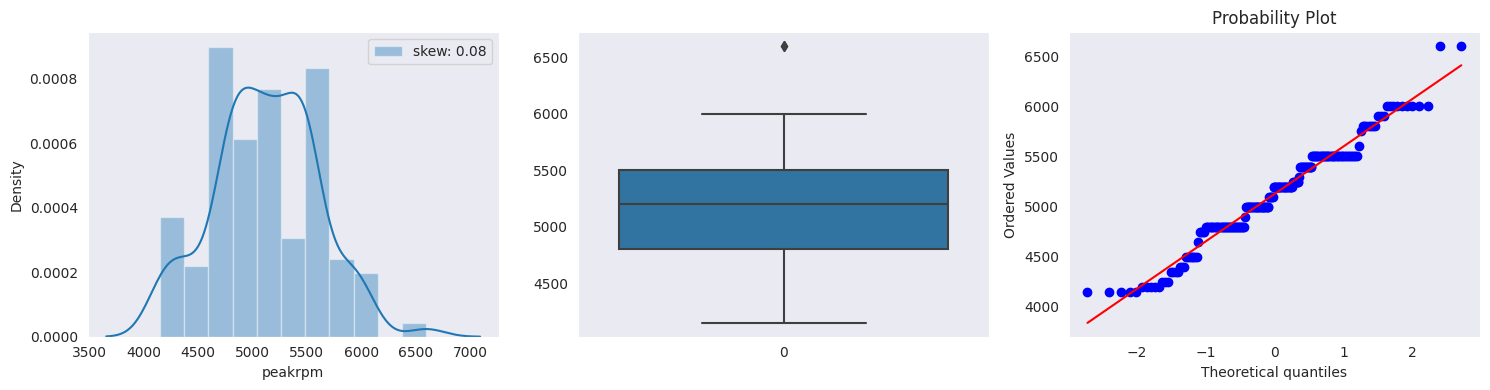

<ipython-input-111-32897acfbb08>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], label="skew: " + str(np.round(df[col].skew(),2)))


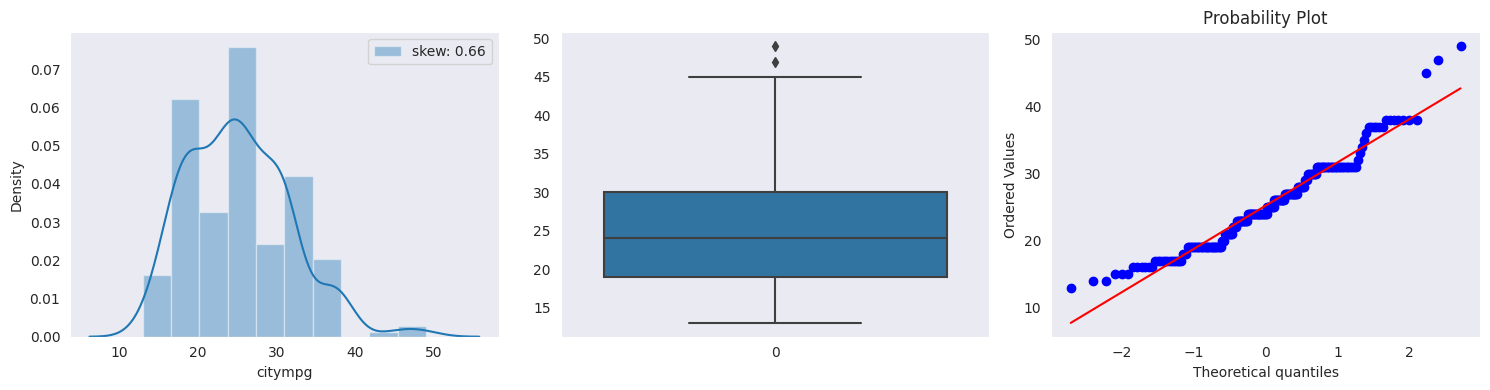

<ipython-input-111-32897acfbb08>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], label="skew: " + str(np.round(df[col].skew(),2)))


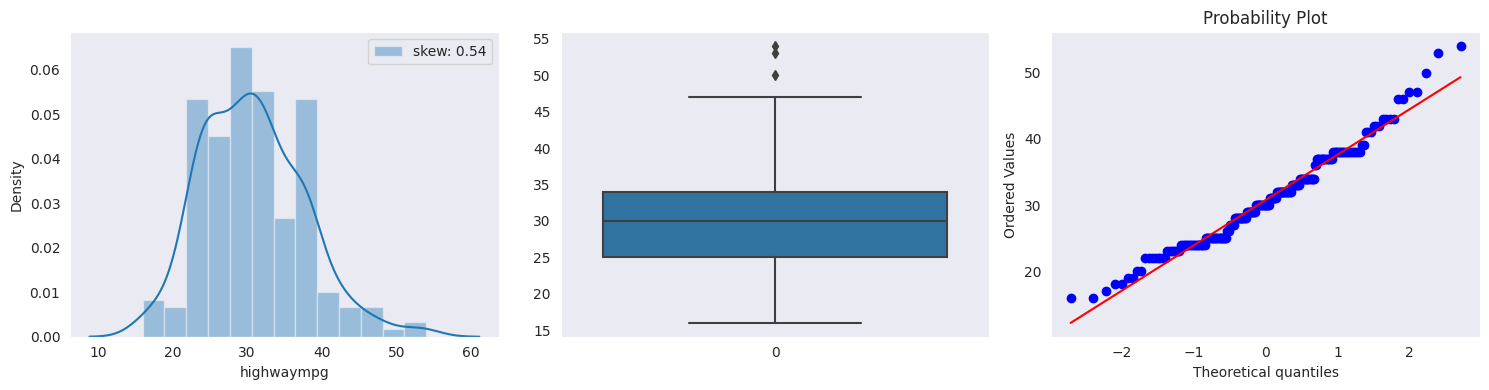

<ipython-input-111-32897acfbb08>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], label="skew: " + str(np.round(df[col].skew(),2)))


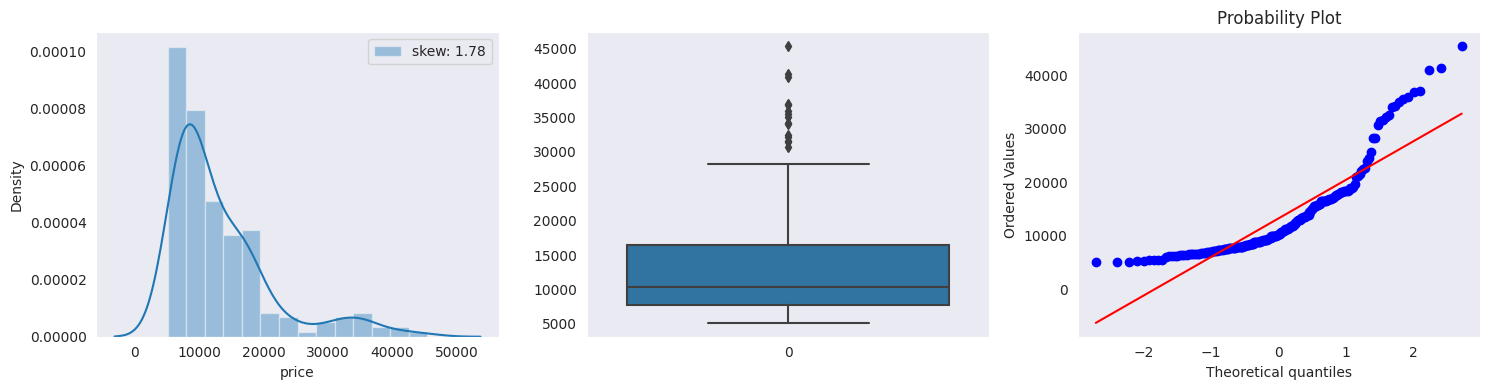

In [111]:
# Ploting graph for each varables to understand outliers
from scipy import stats

df=cars
sns.set_style('dark')
for col in cars.describe().columns:
    plt.figure(figsize=(15,4))
    plt.subplot(131)
    sns.distplot(df[col], label="skew: " + str(np.round(df[col].skew(),2)))
    plt.legend()
    plt.subplot(132)
    sns.boxplot(df[col])
    plt.subplot(133)
    stats.probplot(df[col], plot=plt)
    plt.tight_layout()
    plt.show()

In [112]:
# Finding skew before and after to compare the shape after treatment
# We can use SD, IQR, SKEW etc

for X in cars.describe().columns:
    print('The skewness and Max_Z-Score value for {} is {} and {} respectively'.format(X,cars[X].skew(),np.max(abs(stats.zscore(cars[X])))))

The skewness and Max_Z-Score value for car_ID is 0.0 and 1.7236222864675912 respectively
The skewness and Max_Z-Score value for wheelbase is 1.0502137758714858 and 3.6862252135740365 respectively
The skewness and Max_Z-Score value for carlength is 0.1559537713215604 and 2.766741434550069 respectively
The skewness and Max_Z-Score value for carwidth is 0.904003498786254 and 2.98705556854827 respectively
The skewness and Max_Z-Score value for carheight is 0.06312273247192804 and 2.492301615471819 respectively
The skewness and Max_Z-Score value for curbweight is 0.681398189052588 and 2.9079877723438705 respectively
The skewness and Max_Z-Score value for enginesize is 1.9476550452788108 and 4.7926789111561625 respectively
The skewness and Max_Z-Score value for boreratio is 0.02015641810424137 and 2.9230489468762504 respectively
The skewness and Max_Z-Score value for stroke is -0.6897045784233837 and 3.7893106699169268 respectively
The skewness and Max_Z-Score value for compressionratio is 2

In [113]:
cars['enginesize'].quantile([0.01,0.02,0.03,0.04, 0.25, 0.5, 0.9,0.95,0.96,0.97,0.98,0.99,1.0])

0.01     70.00
0.02     79.08
0.03     90.00
0.04     90.00
0.25     97.00
0.50    120.00
0.90    181.00
0.95    201.20
0.96    209.00
0.97    231.00
0.98    256.08
0.99    302.16
1.00    326.00
Name: enginesize, dtype: float64

In [114]:
cars.nunique()

car_ID              205
symboling             6
fueltype              2
aspiration            2
doornumber            2
carbody               5
drivewheel            3
enginelocation        2
wheelbase            53
carlength            75
carwidth             44
carheight            49
curbweight          171
enginetype            7
cylindernumber        7
enginesize           44
fuelsystem            8
boreratio            38
stroke               37
compressionratio     32
horsepower           59
peakrpm              23
citympg              29
highwaympg           30
price               189
car_company          22
dtype: int64

### If needed to treat outlier then use the below method :IQR

In [115]:
# col_sel=['compressionratio','enginesize','carwidth','wheelbase']
# def iqr_capping(df, cols, factor):

#     for col in cols:

#         q1 = df[col].quantile(0.25)
#         q3 = df[col].quantile(0.75)

#         iqr = q3 - q1

#         upper_whisker = q3 + (factor*iqr)
#         lower_whisker = q1 - (factor*iqr)

#         df[col] = np.where(df[col]>upper_whisker, upper_whisker,
#                  np.where(df[col]<lower_whisker, lower_whisker, df[col]))


# iqr_capping(cars, col_sel, 1.5)

In [116]:
# Finding skew before and after to compare the shape after treatment
# We can use SD, IQR, SKEW etc

# for X in cars.describe().columns:
#     print('The skewness and Max_Z-Score value for {} is {} and {} respectively'.format(X,cars[X].skew(),np.max(abs(stats.zscore(cars[X])))))

## 3. Data Preparation


#### Data Preparation

Let's now prepare the data and build the model.

In [117]:
# split into X and y
X = cars.loc[:, ['symboling', 'fueltype', 'aspiration', 'doornumber',
       'carbody', 'drivewheel', 'enginelocation', 'wheelbase', 'carlength',
       'carwidth', 'carheight', 'curbweight', 'enginetype', 'cylindernumber',
       'enginesize', 'fuelsystem', 'boreratio', 'stroke', 'compressionratio',
       'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'car_company']]

y  = cars['price']


In [118]:
# creating dummy variables for categorical variables

# subset all categorical variables
cars_categorical = X.select_dtypes(include=['object'])
cars_categorical.head()

symboling fueltype aspiration doornumber      carbody drivewheel  \
0         3      gas        std        two  convertible        rwd   
1         3      gas        std        two  convertible        rwd   
2         1      gas        std        two    hatchback        rwd   
3         2      gas        std       four        sedan        fwd   
4         2      gas        std       four        sedan        4wd   

  enginelocation enginetype cylindernumber fuelsystem  car_company  
0          front       dohc           four       mpfi  alfa-romero  
1          front       dohc           four       mpfi  alfa-romero  
2          front       ohcv            six       mpfi  alfa-romero  
3          front        ohc           four       mpfi         audi  
4          front        ohc           five       mpfi         audi

In [119]:
# convert into dummies
cars_dummies = pd.get_dummies(cars_categorical, drop_first=True)
cars_dummies.head()

<ipython-input-119-eb2bf133d316>:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  cars_dummies = pd.get_dummies(cars_categorical, drop_first=True)


symboling_-1  symboling_0  symboling_1  symboling_2  symboling_3  \
0             0            0            0            0            1   
1             0            0            0            0            1   
2             0            0            1            0            0   
3             0            0            0            1            0   
4             0            0            0            1            0   

   fueltype_gas  aspiration_turbo  doornumber_two  carbody_hardtop  \
0             1                 0               1                0   
1             1                 0               1                0   
2             1                 0               1                0   
3             1                 0               0                0   
4             1                 0               0                0   

   carbody_hatchback  ...  car_company_nissan  car_company_peugeot  \
0                  0  ...                   0                    0   
1                  0  ...                   0                    0   
2                  1  ...                   0                    0   
3                  0  ...                   0                    0   
4                  0  ...                   0                    0   

   car_company_plymouth  car_company_porsche  car_company_renault  \
0                     0                    0                    0   
1                     0                    0                    0   
2                     0                    0                    0   
3                     0                    0                    0   
4                     0                    0                    0   

   car_company_saab  car_company_subaru  car_company_toyota  \
0                 0                   0                   0   
1                 0                   0                   0   
2                 0                   0                   0   
3                 0                   0                   0   
4                 0                   0                   0   

   car_company_volkswagen  car_company_volvo  
0                       0                  0  
1                       0                  0  
2                       0                  0  
3                       0                  0  
4                       0                  0  

[5 rows x 55 columns]

In [120]:
# drop categorical variables
X = X.drop(list(cars_categorical.columns), axis=1)

In [121]:
# concat dummy variables with X
X = pd.concat([X, cars_dummies], axis=1)

### VIF calculation

In [122]:
# Let's check multicollinearity
# to calculated VIF we can use the loop
Default_indep=X
VIF=[]

import statsmodels.api as sm
features=list(Default_indep.columns)
for i in range(1, len(Default_indep.columns)):
    x=Default_indep.loc[:,Default_indep.columns!=features[i]]
    y=Default_indep.loc[:,Default_indep.columns==features[i]]
    model=sm.OLS(y,x)
    results=model.fit()

    rsq=results.rsquared
    vif=round(1/(1-rsq),2)
    print ("R-Sqr value of {} is {}".format(features[i],rsq))
    print ('VIF for {} is {}'.format(features[i],vif))
    VIF.append(vif)

R-Sqr value of carlength is 0.9615520802614562
VIF for carlength is 26.01
R-Sqr value of carwidth is 0.9411213147203535
VIF for carwidth is 16.98
R-Sqr value of carheight is 0.8753807839476153
VIF for carheight is 8.02
R-Sqr value of curbweight is 0.9807163556898695
VIF for curbweight is 51.86
R-Sqr value of enginesize is 0.9873747570755251
VIF for enginesize is 79.21
R-Sqr value of boreratio is 0.9418444837825323
VIF for boreratio is 17.2
R-Sqr value of stroke is 0.8512704421600654
VIF for stroke is 6.72
R-Sqr value of compressionratio is 0.9962659027271956
VIF for compressionratio is 267.8
R-Sqr value of horsepower is 0.9844179641794818
VIF for horsepower is 64.18
R-Sqr value of peakrpm is 0.8706150744058966
VIF for peakrpm is 7.73
R-Sqr value of citympg is 0.9808509717996745
VIF for citympg is 52.22
R-Sqr value of highwaympg is 0.9771191155287562
VIF for highwaympg is 43.7
R-Sqr value of symboling_-1 is 0.9061305704359136
VIF for symboling_-1 is 10.65
R-Sqr value of symboling_0 is 0

<ipython-input-122-bd12ee556fa5>:15: RuntimeWarning: divide by zero encountered in double_scalars
  vif=round(1/(1-rsq),2)



VIF for car_company_dodge is 9.72
R-Sqr value of car_company_honda is 0.946662023877169
VIF for car_company_honda is 18.75
R-Sqr value of car_company_isuzu is 0.8124014545301697
VIF for car_company_isuzu is 5.33
R-Sqr value of car_company_jaguar is 0.870803585787442
VIF for car_company_jaguar is 7.74
R-Sqr value of car_company_mazda is 0.932381772308898
VIF for car_company_mazda is 14.79
R-Sqr value of car_company_mercury is 0.651646225817827
VIF for car_company_mercury is 2.87
R-Sqr value of car_company_mitsubishi is 0.9284316577020171
VIF for car_company_mitsubishi is 13.97
R-Sqr value of car_company_nissan is 0.9338498180489639
VIF for car_company_nissan is 15.12
R-Sqr value of car_company_peugeot is 1.0
VIF for car_company_peugeot is inf
R-Sqr value of car_company_plymouth is 0.8678905074911845
VIF for car_company_plymouth is 7.57
R-Sqr value of car_company_porsche is 0.928210202298062
VIF for car_company_porsche is 13.93
R-Sqr value of car_company_renault is 0.700122331572478
VIF

In [123]:
VIF_master = pd.DataFrame(zip(list(Default_indep.columns), VIF), columns=['Feature', 'VIF'])

#### We see high multicollinearity with features, can treat them with PCA or iterative method

In [124]:
# # scaling the features
# from sklearn.preprocessing import scale

# # storing column names in cols, since column names are (annoyingly) lost after
# # scaling (the df is converted to a numpy array)
# cols = X.columns
# X = pd.DataFrame(scale(X))
# X.columns = cols
# X.columns

In [125]:
# # split into train and test
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     train_size=0.6,
#                                                     test_size = 0.4, random_state=100)

In [126]:
# ONE HOT ENCODING

In [127]:
# creating a linear model
print(X), print(y)
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.25, random_state=1)

     wheelbase  carlength  carwidth  carheight  curbweight  enginesize  \
0         88.6      168.8      64.1       48.8        2548         130   
1         88.6      168.8      64.1       48.8        2548         130   
2         94.5      171.2      65.5       52.4        2823         152   
3         99.8      176.6      66.2       54.3        2337         109   
4         99.4      176.6      66.4       54.3        2824         136   
..         ...        ...       ...        ...         ...         ...   
200      109.1      188.8      68.9       55.5        2952         141   
201      109.1      188.8      68.8       55.5        3049         141   
202      109.1      188.8      68.9       55.5        3012         173   
203      109.1      188.8      68.9       55.5        3217         145   
204      109.1      188.8      68.9       55.5        3062         141   

     boreratio  stroke  compressionratio  horsepower  ...  car_company_nissan  \
0         3.47    2.68        

## 3. Model Building and Evaluation

In [128]:
from sklearn.linear_model import LinearRegression

In [129]:
# creating a linear model
lm = LinearRegression()

print(X)
print(y)

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

lm.fit(x_train, y_train)

print(lm.coef_)

Coef_df = pd.DataFrame(zip(x_train.columns, lm.coef_))
Coef_df.transpose()


     wheelbase  carlength  carwidth  carheight  curbweight  enginesize  \
0         88.6      168.8      64.1       48.8        2548         130   
1         88.6      168.8      64.1       48.8        2548         130   
2         94.5      171.2      65.5       52.4        2823         152   
3         99.8      176.6      66.2       54.3        2337         109   
4         99.4      176.6      66.4       54.3        2824         136   
..         ...        ...       ...        ...         ...         ...   
200      109.1      188.8      68.9       55.5        2952         141   
201      109.1      188.8      68.8       55.5        3049         141   
202      109.1      188.8      68.9       55.5        3012         173   
203      109.1      188.8      68.9       55.5        3217         145   
204      109.1      188.8      68.9       55.5        3062         141   

     boreratio  stroke  compressionratio  horsepower  ...  car_company_nissan  \
0         3.47    2.68        

0
0                                          wheelbase
1  [1.7904448118438738e-17, -7.188260403578894e-1...

In [130]:
Coef_df=pd.DataFrame(zip(x_train.columns,lm.coef_))
Coef_df.transpose()

0
0                                          wheelbase
1  [1.7904448118438738e-17, -7.188260403578894e-1...

In [131]:
# print coefficients and intercept
print(lm.coef_)
print(lm.intercept_)

[[ 1.79044481e-17 -7.18826040e-17  2.56305394e-16 -2.13804668e-16
  -3.12250226e-17  4.33680869e-17 -3.46944695e-16  2.28983499e-16
  -2.56739074e-16 -1.38777878e-17  4.85722573e-17 -5.55111512e-17
   0.00000000e+00  2.22044605e-16  7.28583860e-17 -5.37764278e-16
  -5.23886490e-16 -1.06165077e-15 -1.17267307e-15  1.40512602e-15
   2.08166817e-17  0.00000000e+00  6.38378239e-16  1.09634524e-15
   1.44328993e-15 -1.94289029e-15 -1.33226763e-15 -1.24900090e-16
   1.49880108e-15 -1.06858966e-15 -7.21644966e-16 -5.96744876e-16
  -1.66533454e-15 -1.31838984e-16 -2.49800181e-16  2.98372438e-16
   1.69309011e-15  1.04083409e-16  3.89965837e-15 -2.35922393e-16
   7.84095011e-16 -3.64291930e-16  1.13103971e-15 -2.22044605e-16
   1.19348975e-15  0.00000000e+00 -7.59808882e-16 -1.20042865e-15
  -1.17267307e-15 -1.37390099e-15 -2.10942375e-15 -2.53963517e-15
  -2.15105711e-15  2.91433544e-16 -5.74540415e-15 -1.55431223e-15
  -5.41233725e-16 -1.65145675e-15 -6.93889390e-16 -6.31439345e-16
  -2.26207

In [132]:
# Get all the model performace parameters
# we can get train error

y_train_pred=lm.predict(x_train)

from sklearn import metrics

mean_l1_error_train=metrics.mean_absolute_error(y_train,y_train_pred)
mean_l2_error_train=metrics.mean_squared_error(y_train,y_train_pred)
Rootmean_l2_error_train=np.sqrt(metrics.mean_squared_error(y_train,y_train_pred))

train_accuracy = lm.score(x_train, y_train)
# lm.score(x_train,y_train) same as above
print("mean_l1_error_train is {} mean_l2_error_train is {} Rootmean_l2_error_train is {} and accuracy is {}".format(mean_l1_error_train,mean_l2_error_train,Rootmean_l2_error_train,train_accuracy))

mean_l1_error_train is 2.3094241718420798e-14 mean_l2_error_train is 8.855209327482708e-28 Rootmean_l2_error_train is 2.9757703754629164e-14 and accuracy is 1.0


In [133]:
# model parameters and annova
x_train_final=sm.add_constant(x_train)
model_object=sm.OLS(y_train,x_train_final)
model=model_object.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      car_company_volvo   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.746e+23
Date:                Sat, 05 Aug 2023   Prob (F-statistic):               0.00
Time:                        09:56:34   Log-Likelihood:                 4171.1
No. Observations:                 153   AIC:                            -8218.
Df Residuals:                      91   BIC:                            -8030.
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   4.56

In [134]:
DF_y_train_pred=pd.DataFrame(y_train_pred,columns=['price_predict'])
x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
DF_y_train_pred.reset_index(drop=True, inplace=True)

Train_with_pred=pd.concat([x_train,y_train,DF_y_train_pred], axis=1)
Train_with_pred

wheelbase  carlength  carwidth  carheight  curbweight  enginesize  \
0        103.5      189.0      66.9       55.7        3055         164   
1         95.7      166.3      64.4       52.8        2140          98   
2         98.8      177.8      66.5       53.7        2385         122   
3         94.5      155.9      63.6       52.0        1874          90   
4        102.4      175.6      66.5       53.9        2458         122   
..         ...        ...       ...        ...         ...         ...   
148       99.1      186.6      66.5       56.1        2695         121   
149       99.1      186.6      66.5       56.1        2847         121   
150       96.6      180.3      70.5       50.8        3685         234   
151       93.3      157.3      63.8       55.7        2240         108   
152       96.5      167.5      65.2       53.3        2236         110   

     boreratio  stroke  compressionratio  horsepower  ...  \
0         3.31    3.19               9.0         121  ...   
1         3.19    3.03               9.0          70  ...   
2         3.39    3.39               8.6          84  ...   
3         3.03    3.11               9.6          70  ...   
4         3.31    3.54               8.7          92  ...   
..         ...     ...               ...         ...  ...   
148       3.54    3.07               9.3         110  ...   
149       3.54    3.07               9.0         160  ...   
150       3.46    3.10               8.3         155  ...   
151       3.62    2.64               8.7          73  ...   
152       3.15    3.58               9.0          86  ...   

     car_company_plymouth  car_company_porsche  car_company_renault  \
0                       0                    0                    0   
1                       0                    0                    0   
2                       0                    0                    0   
3                       0                    0                    0   
4                       0                    0                    0   
..                    ...                  ...                  ...   
148                     0                    0                    0   
149                     0                    0                    0   
150                     0                    0                    0   
151                     0                    0                    0   
152                     0                    0                    0   

     car_company_saab  car_company_subaru  car_company_toyota  \
0                   0                   0                   0   
1                   0                   0                   1   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   1   
..                ...                 ...                 ...   
148                 1                   0                   0   
149                 1                   0                   0   
150                 0                   0                   0   
151                 0                   1                   0   
152                 0                   0                   0   

     car_company_volkswagen  car_company_volvo  car_company_volvo  \
0                         0                  0                  0   
1                         0                  0                  0   
2                         0                  0                  0   
3                         0                  0                  0   
4                         0                  0                  0   
..                      ...                ...                ...   
148                       0                  0                  0   
149                       0                  0                  0   
150                       0                  0                  0   
151                       0                  0             

In [135]:
# Get the model tested on test data

y_test_pred=lm.predict(x_test)

from sklearn import metrics

mean_l1_error_test=metrics.mean_absolute_error(y_test,y_test_pred)
mean_l2_error_test=metrics.mean_squared_error(y_test,y_test_pred)
Rootmean_l2_error_test=round(np.sqrt(metrics.mean_squared_error(y_test,y_test_pred)),10)
# Rootmean_l2_error_test=round(np.sqrt(metrics.mean_squared_error(y_test,y_test_pred)),10)

test_accuracy = lm.score(x_test, y_test)
print(pd.DataFrame(zip(x_test,y_test,y_test_pred)))
print("mean_l1_error_test is {} mean_l2_error_test is {} Rootmean_l2_error_test is {} and rmse_test is {}".format(mean_l1_error_test,mean_l2_error_test,Rootmean_l2_error_test,test_accuracy))

           0                  1                         2
0  wheelbase  car_company_volvo  [3.5100635557686204e-14]
mean_l1_error_test is 2.5246516201435473e-14 mean_l2_error_test is 1.0676847981821409e-27 Rootmean_l2_error_test is 0.0 and rmse_test is 1.0


In [136]:
DF_y_test_pred=pd.DataFrame(y_test_pred,columns=['price_predict'])
x_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
DF_y_test_pred.reset_index(drop=True, inplace=True)

Test_with_pred=pd.concat([x_test,y_test,DF_y_test_pred], axis=1)
Test_with_pred

wheelbase  carlength  carwidth  carheight  curbweight  enginesize  \
0        93.7      157.3      64.4       50.8        2004          92   
1        94.5      170.2      63.8       53.5        2037          97   
2        95.7      158.7      63.6       54.5        2040          92   
3        94.5      155.9      63.6       52.0        1874          90   
4        96.5      175.4      62.5       54.1        2372         110   
5       110.0      190.9      70.3       56.5        3515         183   
6        95.1      162.4      63.8       53.3        2008          97   
7        88.4      141.1      60.3       53.2        1488          61   
8        95.7      158.7      63.6       54.5        2015          92   
9        98.8      177.8      66.5       55.5        2410         122   
10       99.4      176.6      66.4       54.3        2824         136   
11       98.4      176.2      65.6       53.0        2975         146   
12      104.3      188.8      67.2       57.5        3042         141   
13       96.5      167.5      65.2       53.3        2289         110   
14       95.9      173.2      66.3       50.2        2811         156   
15       98.4      176.2      65.6       52.0        2679         146   
16       94.5      165.7      64.0       51.4        2221         109   
17       93.7      150.0      64.0       52.6        1940          92   
18       99.1      186.6      66.5       56.1        2808         121   
19       97.0      172.0      65.4       54.3        2510         108   
20      102.4      175.6      66.5       54.9        2326         122   
21       86.6      144.6      63.9       50.8        1819          92   
22      101.2      176.8      64.8       54.3        2395         108   
23       93.7      157.3      63.8       50.8        2128          98   
24       98.4      176.2      65.6       52.0        2551         146   
25       93.7      150.0      64.0       52.6        1956          92   
26       95.9      173.2      66.3       50.2        2926         156   
27       97.3      171.7      65.5       55.7        2264          97   
28       93.7      157.3      63.8       50.6        1967          90   
29       96.5      163.4      64.0       54.5        2010          92   
30       94.5      168.7      64.0       52.6        2169          98   
31      103.3      174.6      64.6       59.8        2535         122   
32      103.5      193.8      67.9       53.7        3380         209   
33       96.1      181.5      66.5       55.2        2579         132   
34      107.9      186.7      68.4       56.7        3252         152   
35       97.3      171.7      65.5       55.7        2261          97   
36       93.7      157.3      63.8       50.6        2191          98   
37      113.0      199.6      69.6       52.8        4066         258   
38       95.3      169.0      65.7       49.6        2500          80   
39      109.1      188.8      68.9       55.5        3062         141   
40       93.7      156.9      63.4       53.7        2050          97   
41       99.2      178.5      67.9       49.7        3139         181   
42       94.5      165.3      63.8       54.5        2017         103   
43       97.0      173.5      65.4       53.0        2455         108   
44       97.3      171.7      65.5       55.7        2212         109   
45       94.5      165.6      63.8       53.3        2028          97   
46      120.9      208.1      71.7       56.7        3900         308   
47       93.1      159.1      64.2       54.1        1900          91   
48      108.0      186.7      68.3       56.0        3130         134   
49      100.4      184.6      66.5       55.1        3060         181   
50      106.7      187.5      70.3       54.9        3495         183   
51      107.9      186.7      68.4       56.7        3020         120   

    boreratio  stroke  compressionratio  horsepower  ...  \
0        2.97   3.230               9.4          68  ...   
1        3.15 